In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### Binomial Stock Price Model

Given values of $\mu$, $\sigma$, and $T$, we calculate the array of ending stock prices for a binomial tree with $n$ levels. For this, we define $\Delta t = \frac{T}{n}$. Following the calibration discussion in class, we set values for the parameters as:
- $u = e^{\mu\Delta t}\left(1 + \sqrt{e^{\sigma^2\Delta t} - 1}\right)$
- $d = e^{\mu\Delta t}\left(1 - \sqrt{e^{\sigma^2\Delta t} - 1}\right)$
- $p = \frac{1}{2}$

As you change from small to large values of $n$ below, you'll see how the empirical CDF of $S_T$ approaches the theoretical CDF of the corresponding lognormal distribution that we derived in the context of Geometric Brownian Motion. That means, as $\Delta t \rightarrow 0$, the distribution of the stock price at time $T$ from the binomial model approaches the distribution of stock price at time $T$ from the Geometric Brownian Motion model.

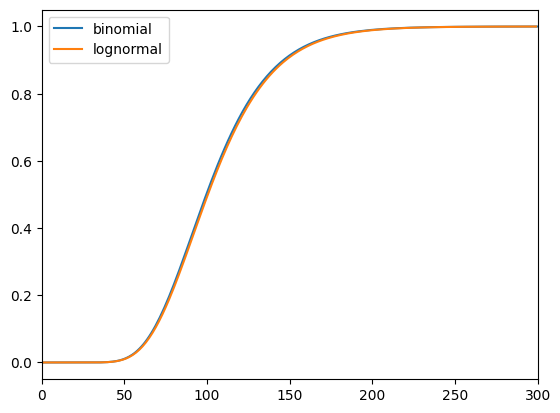

In [ ]:
mu = 0.05; sigma = 0.30; T = 1; n = 1000; dt = T / n
u = np.exp(mu*dt) * (1 + np.sqrt(np.exp(sigma**2 * dt) - 1))
d = np.exp(mu*dt) * (1 - np.sqrt(np.exp(sigma**2 * dt) - 1))
p = 1/2
S_0 = 100
S_T = np.zeros(n+1)
prob = np.zeros(n+1)
for i in range(n+1):
  S_T[i] = S_0 * (u**i) * (d**(n-i))
  prob[i] = stats.binom.pmf(i, n, p)
# plt.bar(S_T, prob)
plt.plot(S_T, prob.cumsum(), label = 'binomial')
plt.plot(np.arange(0, 300), stats.lognorm.cdf(np.arange(0, 300), scale = S_0*np.exp((mu-1/2*sigma**2)*T), s = sigma*np.sqrt(T)), label='lognormal')
plt.xlim((0, 300))
plt.legend()

### Option Pricing

As discussed in class, we'll use risk-neutral valuation for pricing options. For this, we'll use the risk-free rate $r_f$ instead of the stock's expected return $\mu$ to develop the stock price tree. The parameters are defined as follows:
- $u = e^{\sigma\sqrt{T}}$
- $d = e^{-\sigma\sqrt{T}}$
- $q = \frac{e^{r_f\Delta t}-d}{u-d}$

Here, $q$ represents the risk-neutral probability. For a different approach, we can also use the values of $u$ and $d$ outlined at the top of this page after replacing $\mu$ with $r_f$. In that case, $q$ will be $\frac{1}{2}$.

For pricing European options, we don't need to develop the entire stock price tree and will only generate the stock price at expiration.

In [ ]:
# generating stock price at expiration
def gen_S_T(S_0, sigma, T, n):
  dt = T / n
  u = np.exp(sigma * np.sqrt(dt)); d = 1/u
  S_T = np.zeros(n+1)
  for i in range(n+1):
    S_T[i] = S_0 * (u**(n-i)) * (d**i)
  return (u, d, S_T)

In [ ]:
S_0 = 100; sigma = 0.20; T = 1; n = 3
gen_S_T(S_0, sigma, T, n)

(1.1224009024456676,
 0.8909472522884107,
 array([141.39824581, 112.24009024,  89.09472523,  70.72223522]))

The value of a European call option is the discounted expected payoff at expiration. This involves four steps:
- Calculate the payoff of the call at expiration;
- Calculate the probability of each node at expiration;
- Calculate the expected payoff using the the steps above;
- Discount back using the risk-free rate

Note that we're using the risk-free rate because the probabilities here are not the real-worl probabilities, but the risk-neutral probabilities.

In [ ]:
def european_call(S_0, K, rf, sigma, T, n):
  dt = T / n
  u, d, S_T = gen_S_T(S_0, sigma, T, n)
  q = (np.exp(rf*dt)-d) / (u-d)
  C_T = np.clip(S_T - K, 0, None)
  prob = stats.binom.pmf(np.arange(n, -1, -1), n, q)
  C_0 = np.exp(-n*rf*dt)*(prob * C_T).sum()
  return C_0

In [ ]:
S_0 = 100; K = 100; rf = 0.06; sigma = 0.20; T = 1; n = 3
european_call(S_0, K, rf, sigma, T, n)

11.551973176964255

Here, you can see how the model behaves with increasing $n$. Try changing the value of the strike price and observe the result.

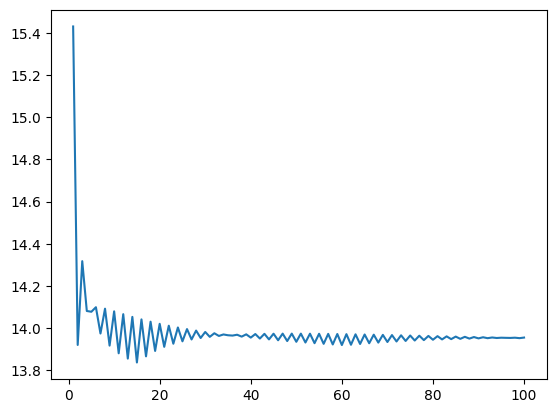

In [ ]:
N = 100
c = np.zeros(N)
for n in range(N):
  c[n] = european_call(S_0, 0.95*S_0, rf, sigma, T, n+1)
plt.plot(np.arange(1, N+1), c)

Pricing a European put is almost identical to pricing a call except for the payoff at expiration.

In [ ]:
def european_put(S_0, K, rf, sigma, T, n):
  dt = T / n
  u, d, S_T = gen_S_T(S_0, sigma, T, n)
  q = (np.exp(rf*dt)-d) / (u-d)
  P_T = np.clip(K - S_T, 0, None)
  prob = stats.binom.pmf(np.arange(n, -1, -1), n, q)
  P_0 = np.exp(-n*rf*dt)*(prob * P_T).sum()
  return P_0

The same comment applies for the put behavior with changing $n$.

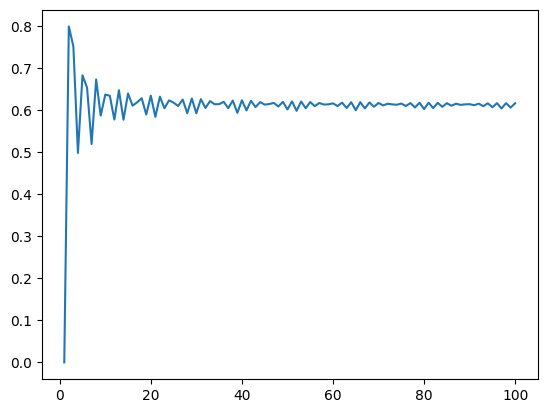

In [ ]:
N = 100
c = np.zeros(N)
for n in range(N):
  c[n] = european_put(S_0, 0.80*S_0, rf, sigma, T, n+1)
plt.plot(np.arange(1, N+1), c)

American options provide the opportunity for early exercise, i.e. you can exit the contract early and get the payoff *before* expiration at $T$. In this case, we have to examine every node individually to check if the option is worth exercising at that node or not. Details are in the class notes. As a result, we now have the generate the entire stock price tree and not just the stock prices at expiration like we did with European options.

In [ ]:
# generate full stock price tree
def gen_stock_tree(S_0, sigma, T, n):
  dt = T/n
  u = np.exp(sigma * np.sqrt(dt)); d = 1/u
  S = np.zeros((n+1, n+1))
  S[0,0] = S_0
  for j in range(1, n+1):
    S[:,j] = S[:,j-1] * u
    S[j,j] = S[j-1,j-1] * d
  return (u, d, S)

In [ ]:
gen_stock_tree(S_0, sigma, T, 3)

(1.1224009024456676,
 0.8909472522884107,
 array([[100.        , 112.24009024, 125.97837858, 141.39824581],
        [  0.        ,  89.09472523, 100.        , 112.24009024],
        [  0.        ,   0.        ,  79.37870064,  89.09472523],
        [  0.        ,   0.        ,   0.        ,  70.72223522]]))

For a non-dividend paying stock, it is never optimal to exercise an American call early. So, there's no point developing an algorithm for an American call in this case because it will behave just like a European call. However, an American put can in fact be exercised early. Details for the algorithm below are in the notes. The essential step is to compare at each node:
- Payoff if the option is not exercised; and
- Payoff if the option is exercised

and then set the option value to greater of the two values above.

In [ ]:
def american_put(S_0, K, rf, sigma, T, n):
  dt = T / n
  u, d, S = gen_stock_tree(S_0, sigma, T, n)
  q = (np.exp(rf*dt)-d) / (u-d)
  P = np.zeros((n+1, n+1))
  P[:,n] = np.clip(K - S[:,n], 0, None)
  for j in range(n-1, -1, -1):
    for i in range(j+1):
      P[i,j] = max(np.exp(-rf*dt)*(q*P[i,j+1]+(1-q)*P[i+1,j+1]), K-S[i,j])
  return P[0,0]

In [ ]:
american_put(S_0, K, rf, sigma, T, 3)

6.099357008892412

As expected, an American put is always worth more than a European put.

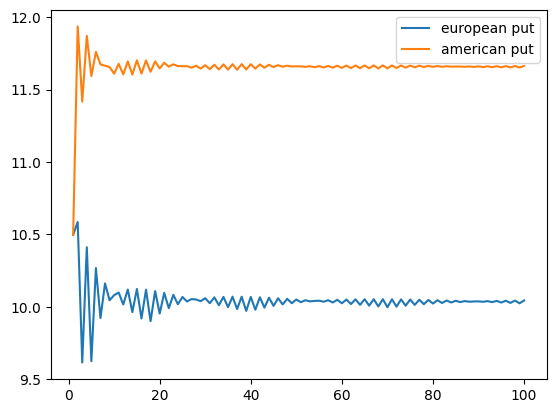

In [ ]:
N = 100
p1 = np.zeros(N)
p2 = np.zeros(N)
for n in range(N):
  p1[n] = european_put(S_0, 1.1*S_0, rf, sigma, T, n+1)
  p2[n] = american_put(S_0, 1.1*S_0, rf, sigma, T, n+1)
plt.plot(np.arange(1, N+1), p1, label = 'european put')
plt.plot(np.arange(1, N+1), p2, label = 'american put')
plt.legend()

An alternate approach to pricing European options is to consider the distribution of $S(T)$ we obtained from the Geometric Brownian Motion assumption. From there, we can again use risk-neutral valuation to calculate the expected payoff of a call (or put) option and then discount back using the risk-free rate. The result is the Black-Scholes-Merton formula for European options (details in notes).

In [ ]:
def bsm_call(S_0, K, rf, sigma, T):
  d1 = (np.log(S_0/K) + (rf + 1/2*sigma**2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  return S_0 * stats.norm.cdf(d1) - K * np.exp(-rf*T) * stats.norm.cdf(d2)
def bsm_put(S_0, K, rf, sigma, T):
  d1 = (np.log(S_0/K) + (rf + 1/2*sigma**2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  return K * np.exp(-rf*T) * stats.norm.cdf(-d2) - S_0 * stats.norm.cdf(-d1)

We can compare how the two models behave. You can see that for strike price within 10% of the stock price, the binomial models converges within around 100 time steps to the BSM value. For strikes beyond that, you might need higher values of $n$.

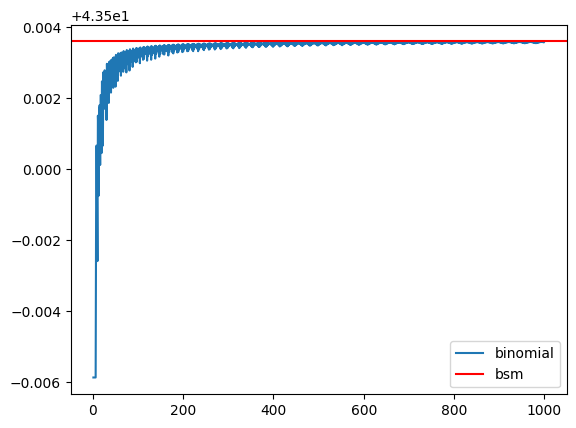

In [ ]:
K = 0.60*S_0
N = 1000
c = np.zeros(N)
for n in range(N):
  c[n] = european_call(S_0, K, rf, sigma, T, n+1)
plt.plot(np.arange(1, N+1), c, label='binomial')
plt.axhline(y = bsm_call(S_0, K, rf, sigma, T), label='bsm', color='red')
plt.legend()